In [114]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt



In [115]:
def get_CSI(CSI_RAW): # Function to extract the CSI information from CSV file rows
    string = CSI_RAW
    res = string.split(' ')
    numbers = []
    for token in res:
        if '[' in token or ']' in token:
            if '[' in token:
                temp = token.split('[')
                if len(temp[1]) > 0:
                    number = int(temp[1])
                    numbers.append(number)
            if ']' in token:
                temp = token.split(']')
                if len(temp[1]) > 0:
                    number = int(temp[1])
                    numbers.append(number)
        else:
            number = int(token)
            numbers.append(number)
    return numbers

def CSI_mean(dict, key):
    arr_CSI = np.array(dict[key])
    if arr_CSI.shape[0] != 128: # hotfix, fix this later maybe (fixing a problem caused by same seq number appearing in two or more bursts)
        mean = np.mean(arr_CSI, axis=0)
        dict[key] = mean

def stack(data):
    i_seq = 2
    i_id = 0
    i_CSI = 3

    current_seq = data[0][i_seq]

    id_STA1 = 841 # put your own IDs here
    id_STA2 = 1
    STA1 = {}
    STA2 = {}
    
    for i,x in enumerate(data): # x = one line in CSV
        seq = x[i_seq] # Seq number
        id = x[i_id] # Station ID
        CSI = x[i_CSI] # CSI 

        if seq == current_seq: # handle consecutive lines with same seq number
            if id == id_STA1: # check the receiver station, STA1
                if seq in STA1.keys(): # append if already seen same seq number
                    STA1[seq].append(CSI)
                else: # new seq number
                    STA1[seq] = [CSI]
            else: # check the receiver station, STA2
                if seq in STA2.keys():
                    STA2[seq].append(CSI)
                else:
                    STA2[seq] = [CSI]
        else: 
            # seq number has changed detected:
            # --> take avg of the CSI vectors, for the previous detected seq number (current_seq), for both station id separately
            # --> However, do this only if the seq number has appeared for both stations
            # --> if the new seq number has not appeared already: start tracking the new seq number
            # --> else: continue (to next new seq number)
            if seq in STA2.keys() or seq in STA1.keys():
                prev = current_seq
                if prev in STA1.keys() and prev in STA2.keys(): # Appeared for both
                    CSI_mean(STA1, prev)
                    CSI_mean(STA2, prev)
                else: # did not appear for both
                    if prev in STA1.keys(): # delete if appeared only for one
                        del STA1[prev]
                    if prev in STA2.keys():
                        del STA2[prev]
                continue
            else:
                prev = current_seq
                if prev in STA1.keys() and prev in STA2.keys(): # Appeared for both
                    CSI_mean(STA1, prev)
                    CSI_mean(STA2, prev)
                else: # did not appear for both
                    if prev in STA1.keys(): # delete if appeared only for one
                        del STA1[prev]
                    if prev in STA2.keys():
                        del STA2[prev]
                current_seq = seq # Start tracking new seq number
                
    prev = current_seq # manually do last one 
    if prev in STA1.keys() and prev in STA2.keys(): # Appeared for both
        CSI_mean(STA1, prev)
        CSI_mean(STA2, prev)
    else: # did not appear for both
        if prev in STA1.keys(): # delete if appeared only for one
            del STA1[prev]
        if prev in STA2.keys():
            del STA2[prev]

    n_seq = len(STA1)
    n_stations = 2
    feature_size = 128 # CSI dimension
    assert(n_seq == len(STA2))

    X = np.zeros((n_seq, n_stations, feature_size)) # the data
    for i, seq in enumerate(STA1):
        CSI_sta1 = STA1[seq]
        CSI_sta2 = STA2[seq]

        X[i, 0, :] = (CSI_sta1)
        X[i, 1, :] = (CSI_sta2)
    
    return X

In [116]:
CSV_FILE_LABELS = ['bed', 'hallway', 'kitchen', 'table', 'window']
preamble = '../data/home_'

n_classes = len(CSV_FILE_LABELS)
CSI_dim = 128
n_stations = 2 # number of ESPs

datas = []
n_data_total = 0 
n_datas = []
for label in CSV_FILE_LABELS:
    filename = preamble + label + '_multi.csv'
    df = pd.read_csv(filename)

    df = df[['device_id', 'rssi', 'seq_ctrl', 'csi_data']] # Relevant columns
    data = df.to_numpy()

    n_data = data.shape[0]
    n_feature = data.shape[1]
    for i,x in enumerate(data):
        for j in range(n_feature-1):
            data[i][j] = int(x[j])
        data[i][n_feature-1] = get_CSI(data[i][n_feature-1])

    
    stacked_CSI = stack(data=data)

    datas.append(stacked_CSI)

    n_data = len(stacked_CSI)
    n_datas.append(n_data)
    n_data_total += n_data



In [117]:
X = np.zeros((n_data_total, n_stations, CSI_dim)) # Features
Y = np.zeros((n_data_total, n_classes)) # Labels
print(Y.shape)

start_index = 0
for i, data in enumerate(datas): # All measurements from a location
    for j, value in enumerate(data): # A measurement from a location
        X[start_index + j,:, :] = value
        Y[start_index + j,i] = 1
    start_index += n_datas[i]

(489, 5)


In [118]:
# shuffle inputs
indsh = (np.arange(n_data_total))
np.random.shuffle(indsh)

X = X[indsh,:,:]
Y = Y[indsh]

X_train = X[:int(0.7 * n_data_total),:]
y_train = Y[:int(0.7 * n_data_total),:]

X_val = X[int(0.7 * n_data_total):int(0.8 * n_data_total),:]
y_val = Y[int(0.7 * n_data_total):int(0.8 * n_data_total),:]

X_test = X[int(0.8 * n_data_total):,:]
y_test = Y[int(0.8 * n_data_total):,:]

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        x = self.feature[idx, :]
        y = self.label[idx, :]
        return x, y

# Create Dataset objects
train_data = CustomDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_data = CustomDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_data = CustomDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create DataLoader for training, validation, and test sets
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [119]:
shared_layers = nn.Sequential(
    nn.Linear(CSI_dim, 256, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 64, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 32, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, 16, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 4, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(4),
    nn.Linear(4, n_classes, bias=True) # Last dim is the amount classes / locations
)

class My_NN(nn.Module):
        def __init__(self):
            super(My_NN, self).__init__()
            self.block = shared_layers

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.zeros_(m.bias)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.ones_(m.weight)
                    nn.init.zeros_(m.bias)

        def forward(self, feature):  # input feature matrix size: CSI_dim = 128
            CSI_1 = feature[:,0,:]
            CSI_2 = feature[:,1,:]
            output1 = (self.block(CSI_1))
            output2 = (self.block(CSI_2))

            return (output1, output2)

100%|██████████| 100/100 [00:05<00:00, 19.14it/s]


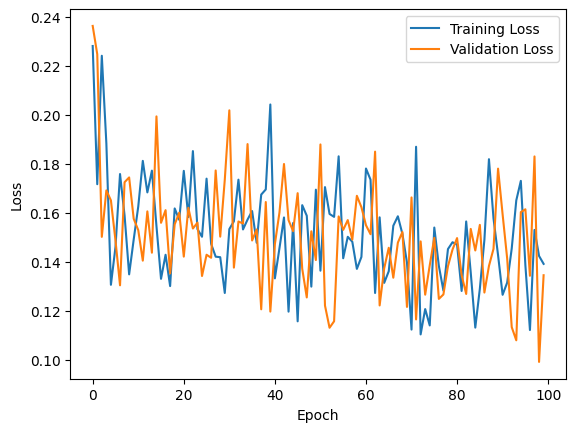

In [120]:
# Initialize the model and other hyperparameters
my_nn = My_NN()
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

my_nn.train()
num_epochs = 100
print_parameters_every = 20  # Print parameters every n epochs
train_losses = []
validation_losses = []
for epoch in tqdm(range(num_epochs)):
    for feature_batch, labels_batch in train_loader:  
        output1, output2 = my_nn(feature_batch)  
        output = torch.stack((output1, output1)).mean(dim=0)
        loss = criterion(output, labels_batch)  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())  # Store training loss
    # validation loop
    with torch.no_grad():
        for feature_batch, labels_batch in val_loader:
            output1, output2 = my_nn(feature_batch)  
            output = torch.stack((output1, output1)).mean(dim=0)
            val_loss = criterion(output, labels_batch)
            # scheduler.step(val_loss)  # you may add the scheduler to avoid over-fitting by reducing learning rate

        validation_losses.append(val_loss.item())
# Plot the training and validation loss
plt.figure(1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [121]:
# test loop
my_nn.eval()
correct = 0
total = 0
with torch.no_grad():
    for feature_batch, labels_batch in test_loader:
        output1, output2 = my_nn(feature_batch)  
        out = torch.stack((output1, output1)).mean(dim=0)
        _,pred = torch.max(out,1)
        _, real = torch.max(labels_batch,1)
        total += len(real)
        correct += (pred == real).sum().item()

print("Accuracy:", correct/total)

Accuracy: 0.5520833333333334
